# Credit Card Default Prediction
___

DSCI 100 - Group 154: Eric Pien, Sydney Quach, Aryan Taneja, Kaila Villarey

## 1. Introduction
___

#### **Background** ####
Credit Cards are an essential part of our daily lives today. Per Statista there were 76M credit cards in circulation within Canada. Also, credit card loan securitization is a huge business for banks and asset managers. As such, a large-scale default could lead to systemic failures of banks and the broader capital markets as observed in GFC.

#### **Thesis** ####
Using the data and the techniques learned in class, we would like to answer the question: **can we predict the default status of a credit card client?**

#### **Data** ####
The data is from a debit and credit card issuing bank in Taiwan. The data consists of information about 30,000 customers as at October 2005, of which 23,364 (78%) have not defaulted while 6,636 (22%) have defaulted. The default status is represented as a binary variable (1 = Yes, 0 = No). 

Variables available to be used as direct inputs are as below:
* **X1**: Amount of Credit Given (NT\$)
* **X2**: Sex (1 = Male, 2 = Female)
* **X3**: Education (1 = Graduate School, 2 = University, 3 = High School, 4 = Others)
* **X4**: Marital Status (1 = Married, 2 = Single, 3 = Others)
* **X5**: Age (# of Years)
* **X6-X11**: Repayment Status (-1 = Clear, 1 = Payment Delay of 1 Month, 2 = Payment Delay of 2 Months, ..., 8 = Payment Delay of 8 Months, 9 = Payment Delay of 9 Months or greater)
    * **X6-11**  = 2005-09 to 2005-04
* **X12-X17**: Amount of Bill Statement (NT\$)
    * **X12-17** = 2005-09 to 2005-04
* **X18-X23**: Amount of Previous Payment (NT\$)
    * **X18-23** = 2005-09 to 2005-04

Source of Data: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

## 2. Methods & Results
___

#### Overview ####
**1. Load, Clean, Split**

* **Environment Setup**: We start by loading in all necessary packages

* **Read & Clean**: 
    * We first read the table from github. 
    * Clean data to match data description and remove non-defined observations and 
    * Check for NAs and data's tidy-ness.
>
* **Feature Engineering**: We test two new features based on the raw inputs:
    1. **balance_pct_0**n: This feature is the % of credit limit drawn and shown as balance on the given month. The feature assumes the credit limit has remained unchanged in the preceeding 6 months and that an individual's balance and credit limit at this specific bank and account fully represents the person's ability to borrow money. The feature is calculated using the following formula:

        $\text{\% Credit Drawn}_\text{t} = \frac{\text{Amount of Bill Statement}_\text{t}}{\text{Amount of Credit Given}}$


    2. **volatility**: This feature is the stadnard deviation of the month over month payment in the preceeding 6 months. The feature is calculated using the following formula:
        
        $\sqrt{ \frac{1}{T} \sum \limits _{i=1} ^{T} {(\text{Payment}_t - \text{Average Payment})^2}}$ 
        
* **Split**: In our study, we split the data 75/25 to leave sufficient amount of data to test our model. 
>
>

**2. Data Exploration**
* **Baseline Performance Benchmark**: We calculate the baseline performance benchmark for the model within the training data as the % of the majority. In this case, 77.69% of the training data's observation was not defaulted so we use this number to measure the value-add of our model.

* **Summary Tables: min, mean, median, max**: We estimate the sample statistics using different grouping to check of obvious issues and patterns with the data.

* **Charts**: We visualize certain data that are best represented in chart format.
>
>

**3. Model Fitting and Testing**
* **Model 1 (Categorical feature only)**: This model consists only of the categorical variables.
* **Model 2 (Engineered feature only)**: This model consists of only the variables that were engineered out of the raw inputs.
* **Model 3 (Manually-selected features)**: This model consinsts of variables that have shown to be additive to the model's predictive power.
>
>

**4. Final Model Selection and Test**
* **Model Selection**: We select the best performing model - the Model 1.
* **Test**: Predictive power falls slightly from just the training set but still exceeds that of the baseline performance benchmark.

### 2.1 Load, Clean, Split ###

#### Environment Setup

In [282]:
# Environment Setup
library(tidyverse)
library(tidymodels)
library(GGally)
library(gridExtra)
library(recipes)
library(kknn)
library(themis)

#### Read & Clean

In [283]:
# Specify column names to make it easier to work with
columns = c('id', 'credit_limit', 'sex', 'education', 'marital_status', 'age',
            'status_09', 'status_08', 'status_07', 'status_06', 'status_05', 'status_04',
            'balance_09', 'balance_08', 'balance_07', 'balance_06', 'balance_05', 'balance_04',
            'payment_09', 'payment_08', 'payment_07', 'payment_06', 'payment_05', 'payment_04',
            'y')
            
# Read from the web into R
credit_card_data <- read_csv('https://raw.githubusercontent.com/ericpien/dsci-100-group-154/main/data/default%20of%20credit%20card%20clients.csv',skip=2,col_names=columns) |>
    select(-id)

# Clean Data and rid of any non-defined observations
credit_card_data <- credit_card_data |>
    mutate(status_09 = status_09+1,
        status_08 = status_08+1,
        status_07 = status_07+1,
        status_06 = status_06+1,
        status_05 = status_05+1,
        status_04 = status_04+1) |>
    filter(marital_status %in% c(1,2,3)) |>
    filter(sex %in% c(1,2)) |>
    filter(education %in% c(1,2,3,4))

# convert variables to factors    
credit_card_data <- credit_card_data |>
    mutate(y = as_factor (y),
            sex = as_factor(sex),
            education = as_factor(education),
            marital_status = as_factor(marital_status),
            status_09 = as_factor(status_09),
            status_08 = as_factor(status_08),
            status_07 = as_factor(status_07),
            status_06 = as_factor(status_06),
            status_05 = as_factor(status_05),
            status_04 = as_factor(status_04))

# Check for NA Data
na_data_count <- sapply(credit_card_data,function(x) sum(is.na(x))) |>
    t() |>
    as_tibble()
    
na_data_count

# Check the data is pre-loaded in tidy format
head(credit_card_data)

Rows: 30000 Columns: 25
-- Column specification --------------------------------------------------------
Delimiter: ","
dbl (25): id, credit_limit, sex, education, marital_status, age, status_09, ...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


credit_limit,sex,education,marital_status,age,status_09,status_08,status_07,status_06,status_05,⋯,balance_06,balance_05,balance_04,payment_09,payment_08,payment_07,payment_06,payment_05,payment_04,y
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


credit_limit,sex,education,marital_status,age,status_09,status_08,status_07,status_06,status_05,⋯,balance_06,balance_05,balance_04,payment_09,payment_08,payment_07,payment_06,payment_05,payment_04,y
<dbl>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
20000,2,2,1,24,3,3,0,0,-1,⋯,0,0,0,0,689,0,0,0,0,1
120000,2,2,2,26,0,3,1,1,1,⋯,3272,3455,3261,0,1000,1000,1000,0,2000,1
90000,2,2,2,34,1,1,1,1,1,⋯,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
50000,2,2,1,37,1,1,1,1,1,⋯,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
50000,1,2,1,57,0,1,0,1,1,⋯,20940,19146,19131,2000,36681,10000,9000,689,679,0
50000,1,1,2,37,1,1,1,1,1,⋯,19394,19619,20024,2500,1815,657,1000,1000,800,0


#### Feature Engineering

In [284]:
# Feature Engineering
credit_card_data <- credit_card_data |>
                    mutate(balance_pct_09 = balance_09 / credit_limit) |>
                    mutate(balance_pct_08 = balance_08 / credit_limit) |>
                    mutate(balance_pct_07 = balance_07 / credit_limit) |>
                    mutate(balance_pct_06 = balance_06 / credit_limit) |>
                    mutate(balance_pct_05 = balance_05 / credit_limit) |>
                    mutate(balance_pct_04 = balance_04 / credit_limit)

credit_card_data <- credit_card_data |> 
                    mutate(payment_mean = (payment_09 + payment_08 + payment_07 + payment_06 + payment_05 + payment_04)/6 ) |>
                    mutate(volatility = sqrt(((payment_09 - payment_mean)^2 +
                                              (payment_08 - payment_mean)^2 +
                                              (payment_07 - payment_mean)^2 +
                                              (payment_06 - payment_mean)^2 +
                                              (payment_05 - payment_mean)^2 +
                                              (payment_04 - payment_mean)^2) / 6))

#### Split

In [285]:
# Split
set.seed(154)
credit_card_split <- credit_card_data |> initial_split(prop=0.75, strata = y)
credit_card_train <- training(credit_card_split)
credit_card_test <- testing(credit_card_split)

### 2.2 Data Exploration ###

#### Baseline Performance Benchmark ###

In [286]:
# Setting up Baseline

credit_card_train |>
    group_by(y) |>
    summarize(default_count=n())|>
    mutate(default_pct = default_count/sum(default_count))

y,default_count,default_pct
<fct>,<int>,<dbl>
0,17247,0.7768919
1,4953,0.2231081


#### Summary Tables

In [287]:
# Summarize the data - count and average demographic profile of clients by default and non-default status

credit_card_train |>
    group_by(y) |>
    summarize(count=n(),
            average_age = mean(age),
            average_credit_limit = mean(credit_limit),
            average_balance_09 = mean(balance_09),
            average_balance_09 = mean(balance_09))

y,count,average_age,average_credit_limit,average_balance_09
<fct>,<int>,<dbl>,<dbl>,<dbl>
0,17247,35.39015,178142.6,52382.82
1,4953,35.64527,131515.8,47883.55


In [289]:
# Summarize the data - count and average demographic profile of clients by sex

credit_card_train |>
    group_by(sex) |>
    summarize(count=n(),
            average_age = mean(age),
            average_credit_limit = mean(credit_limit),
            average_balance_09 = mean(balance_09),
            average_balance_09 = mean(balance_09))

sex,count,average_age,average_credit_limit,average_balance_09
<fct>,<int>,<dbl>,<dbl>,<dbl>
1,8808,36.48899,164417.3,54876.21
2,13392,34.76180,169925.0,49078.85


In [290]:
# Summarize the data - count and average demographic profile of clients by education

credit_card_train |>
    group_by(education) |>
    summarize(count=n(),
            average_age = mean(age),
            average_credit_limit = mean(credit_limit),
            average_balance_09 = mean(balance_09),
            average_balance_09 = mean(balance_09))

education,count,average_age,average_credit_limit,average_balance_09
<fct>,<int>,<dbl>,<dbl>,<dbl>
1,7885,34.20812,213247.9,49532.46
2,10604,34.72105,147226.1,53711.06
3,3624,40.30298,127339.3,48303.86
4,87,33.95402,226436.8,62585.16


In [291]:
# Summarize the data - count and average demographic profile of clients by marital status

credit_card_train |>
    group_by(marital_status) |>
    summarize(count=n(),
            average_age = mean(age),
            average_credit_limit = mean(credit_limit),
            average_balance_09 = mean(balance_09),
            average_balance_09 = mean(balance_09))

marital_status,count,average_age,average_credit_limit,average_balance_09
<fct>,<int>,<dbl>,<dbl>,<dbl>
1,10119,39.96680,183160.98,53308.12
2,11834,31.42488,156069.60,49915.76
3,247,42.99190,95101.21,42452.24


In [292]:
# Summarize the data - count and average demographic profile of clients by payment status

credit_card_train |>
    group_by(status_09) |>
    summarize(count=n(),
            average_age = mean(age),
            average_credit_limit = mean(credit_limit),
            average_balance_09 = mean(balance_09),
            average_balance_09 = mean(balance_09))

status_09,count,average_age,average_credit_limit,average_balance_09
<fct>,<int>,<dbl>,<dbl>,<dbl>
-1,2034,36.98722,250255.65,8443.311
0,4147,36.19918,208314.44,10451.482
1,10980,34.91867,154285.76,78091.323
2,2752,35.34121,149138.81,27651.698
3,1947,35.36466,111543.91,65841.426
4,233,35.42918,85021.46,39023.399
5,57,35.24561,78771.93,67193.930
6,18,35.11111,84444.44,100966.444
7,9,36.11111,84444.44,85770.778


#### Summary of Numericial Columns ###

In [293]:
# Summarize the data - Min, Mean, Median, and Max of the numerical columns by default status (y)

numeric_cols_train <- credit_card_train |>
    select(-sex, -education, -marital_status, -status_09, -status_08, -status_07, -status_06, -status_05, -status_04) |>
    mutate(y = as.numeric(y)-1)

min_0 <- apply(filter(numeric_cols_train, y == 0), 2, min, na.rm = TRUE)
average_0 <- apply(filter(numeric_cols_train, y == 0), 2,  mean, na.rm = TRUE)
median_0 <- apply(filter(numeric_cols_train, y == 0), 2, median, na.rm = TRUE)
max_0 <- apply(filter(numeric_cols_train, y == 0), 2, max, na.rm = TRUE)
min_1 <- apply(filter(numeric_cols_train, y == 1), 2, min, na.rm = TRUE)
average_1 <- apply(filter(numeric_cols_train, y == 1), 2, mean, na.rm = TRUE)
median_1 <- apply(filter(numeric_cols_train, y == 1), 2, median, na.rm = TRUE)
max_1 <- apply(filter(numeric_cols_train, y == 1), 2, max, na.rm = TRUE)

numeric_cols_summary <- rbind(min_0, average_0, median_0, max_0, min_1, average_1, median_1, max_1) |>
    as_tibble() |>
    mutate(info = c('Min','Mean','Median','Max','Min','Mean','Median','Max')) |>
    relocate(y,.before=credit_limit) |>
    relocate(info,.before=credit_limit)

numeric_cols_summary

y,info,credit_limit,age,balance_09,balance_08,balance_07,balance_06,balance_05,balance_04,⋯,payment_05,payment_04,balance_pct_09,balance_pct_08,balance_pct_07,balance_pct_06,balance_pct_05,balance_pct_04,payment_mean,volatility
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,Min,10000.0,21.00000,-15308.00,-67526.00,-157264.00,-170000.00,-81334.00,-209051.00,⋯,0.000,0.000,-0.2309000,-0.9646571,-0.9250824,-1.3745000,-0.8767429,-0.7208655,0.000,0.000
0,Mean,178142.6,35.39015,52382.82,50110.76,47903.33,43961.13,40994.48,39694.07,⋯,5255.274,5690.534,0.4078347,0.3931030,0.3730838,0.3391246,0.3134855,0.2994433,5828.881,5835.919
0,Median,150000.0,34.00000,23900.00,22441.00,20694.00,19262.00,18258.00,17159.00,⋯,1829.000,1740.000,0.2739667,0.2600385,0.2330000,0.2039821,0.1834476,0.1602200,2787.000,1409.675
0,Max,1000000.0,79.00000,964511.00,983931.00,1664089.00,891586.00,927171.00,961664.00,⋯,426529.000,528666.000,6.4553000,6.3805000,10.6885750,5.1468500,4.9355000,3.8855500,627344.333,593455.875
1,Min,10000.0,21.00000,-6029.00,-9119.00,-61506.00,-65167.00,-53007.00,-339603.00,⋯,0.000,0.000,-0.1000000,-0.2989000,-1.0251000,-1.0433000,-0.7500000,-1.2128679,0.000,0.000
1,Mean,131515.8,35.64527,47883.55,46779.31,44618.47,41600.41,39327.82,38206.65,⋯,3345.432,3568.310,0.4828527,0.4795797,0.4619709,0.4328327,0.4064043,0.3950048,3356.980,3426.126
1,Median,90000.0,34.00000,20214.00,20358.00,19783.00,19068.00,18283.00,17932.00,⋯,1000.000,1000.000,0.4753000,0.4739000,0.4458333,0.3945286,0.3647455,0.3443000,1585.833,1071.105
1,Max,740000.0,73.00000,613860.00,581775.00,572677.00,541019.00,547880.00,498316.00,⋯,332000.000,345293.000,3.6099250,3.6981000,3.4760500,2.7982400,2.7320800,2.6941000,117368.000,153588.184


#### Visualization ####

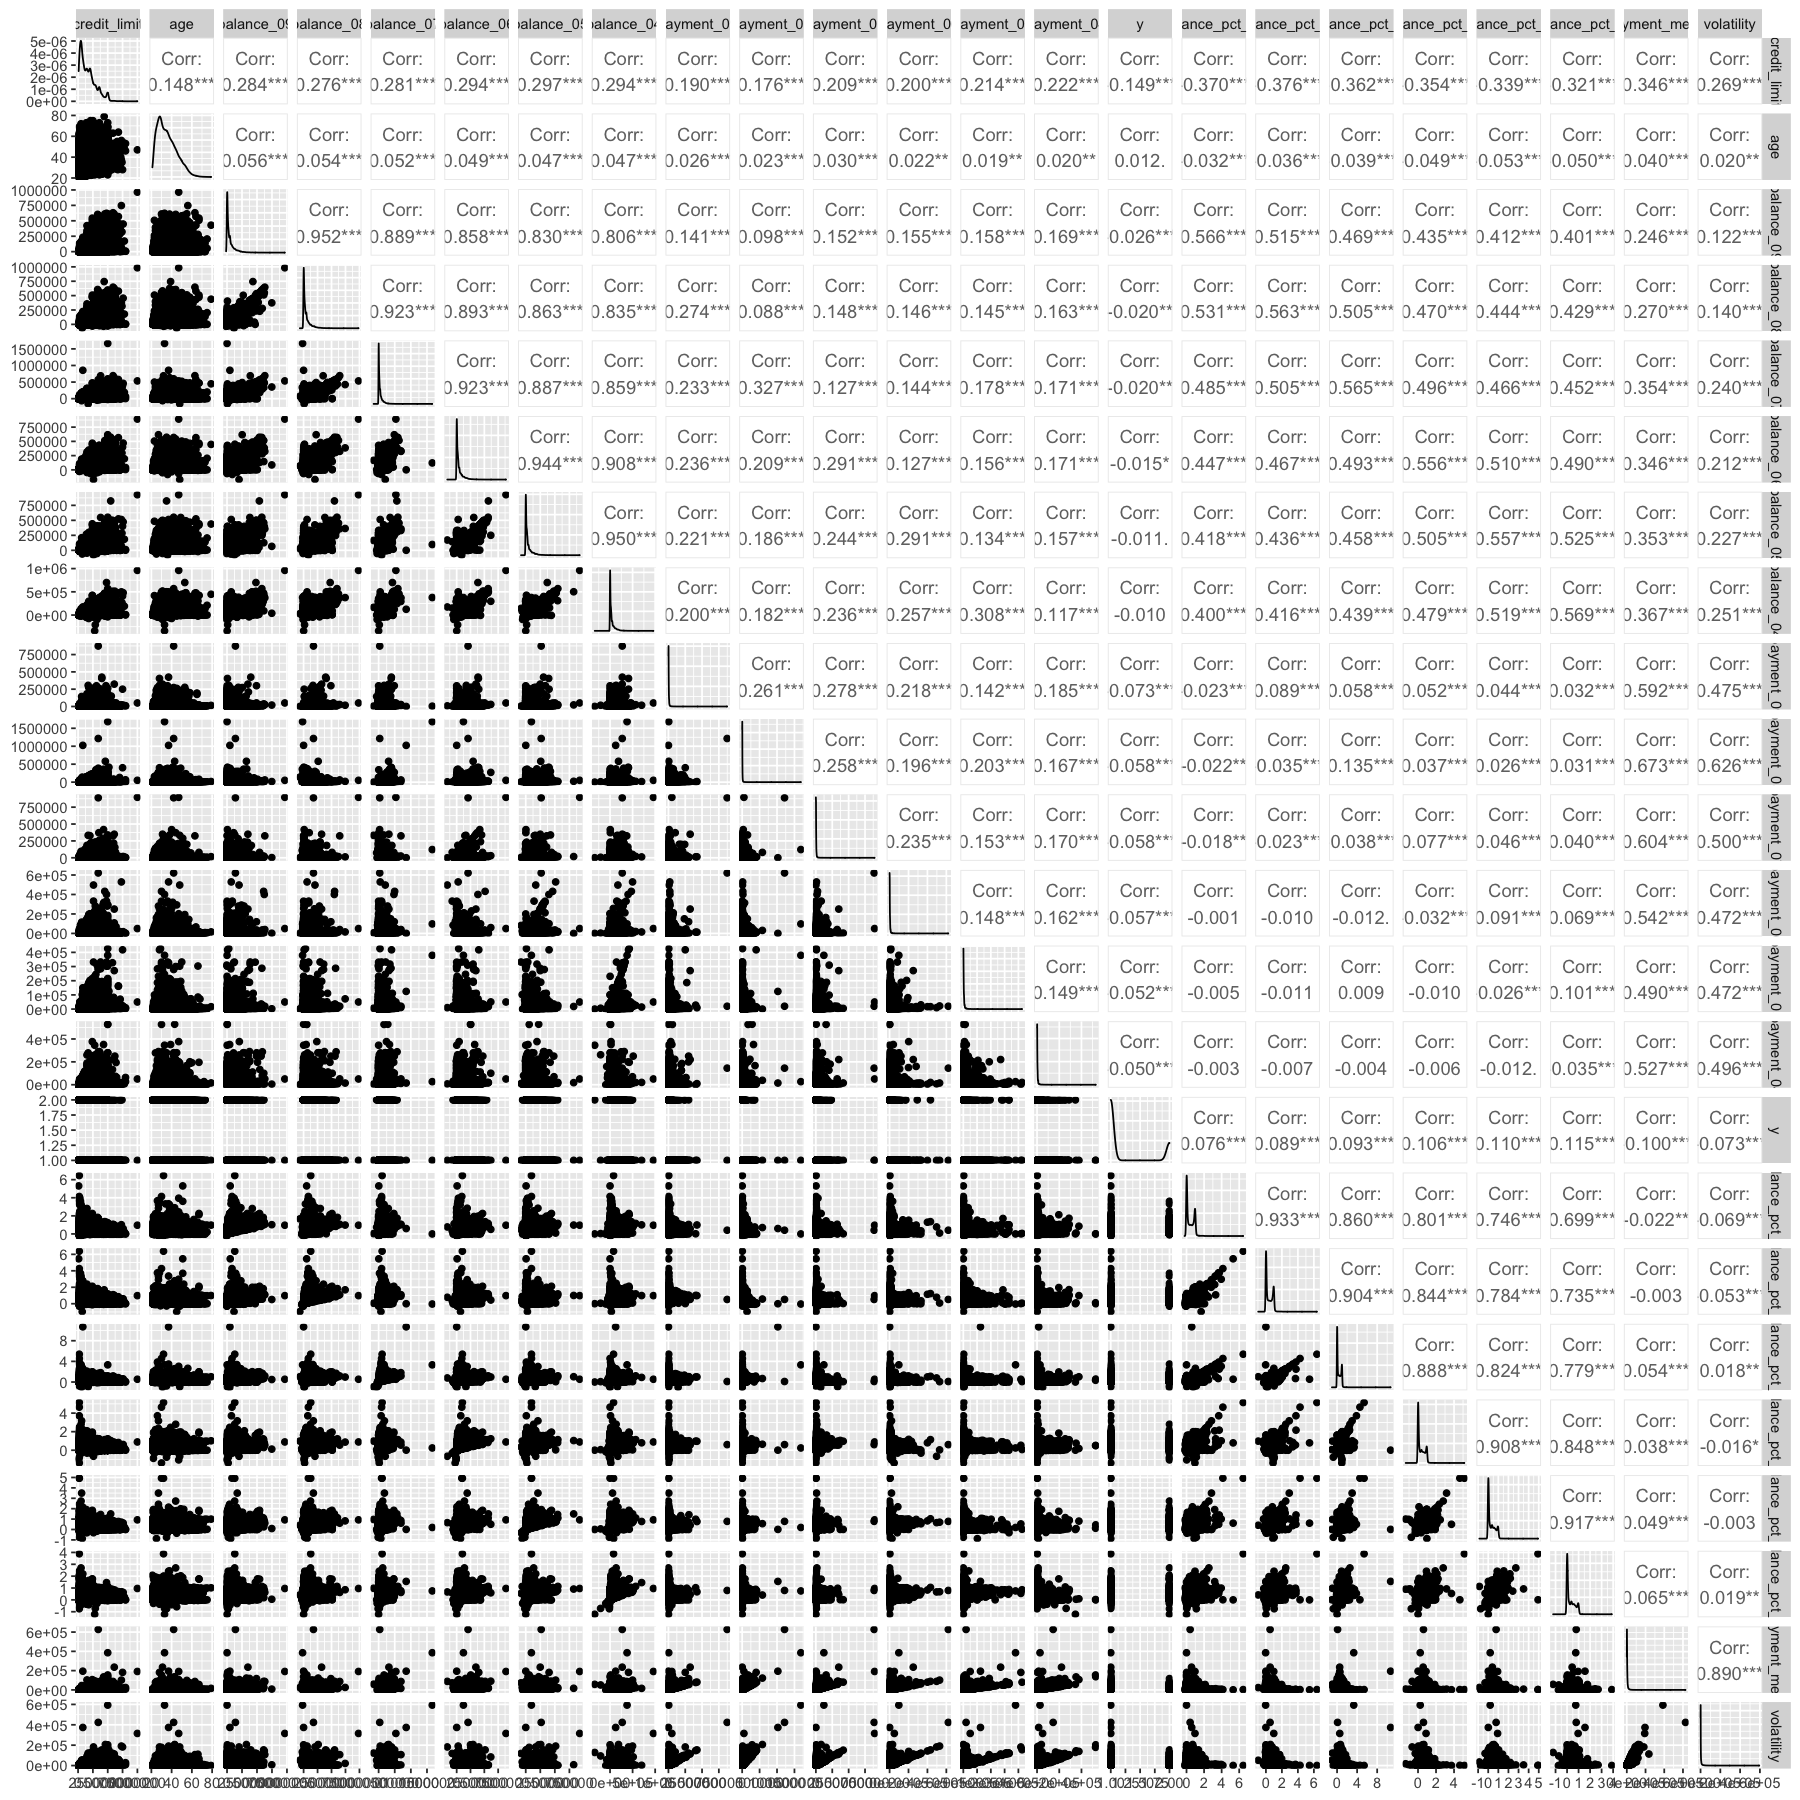

In [304]:
options(repr.plot.width = 15, repr.plot.height = 15)

credit_card_train |> 
    select(-sex, -education, -marital_status, -status_09, -status_08, -status_07, -status_06, -status_05, -status_04) |>
    mutate (y = as.numeric(y))|>
    ggpairs()

`summarise()` has grouped output by 'sex', 'education'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'sex', 'marital_status'. You can override
using the `.groups` argument.


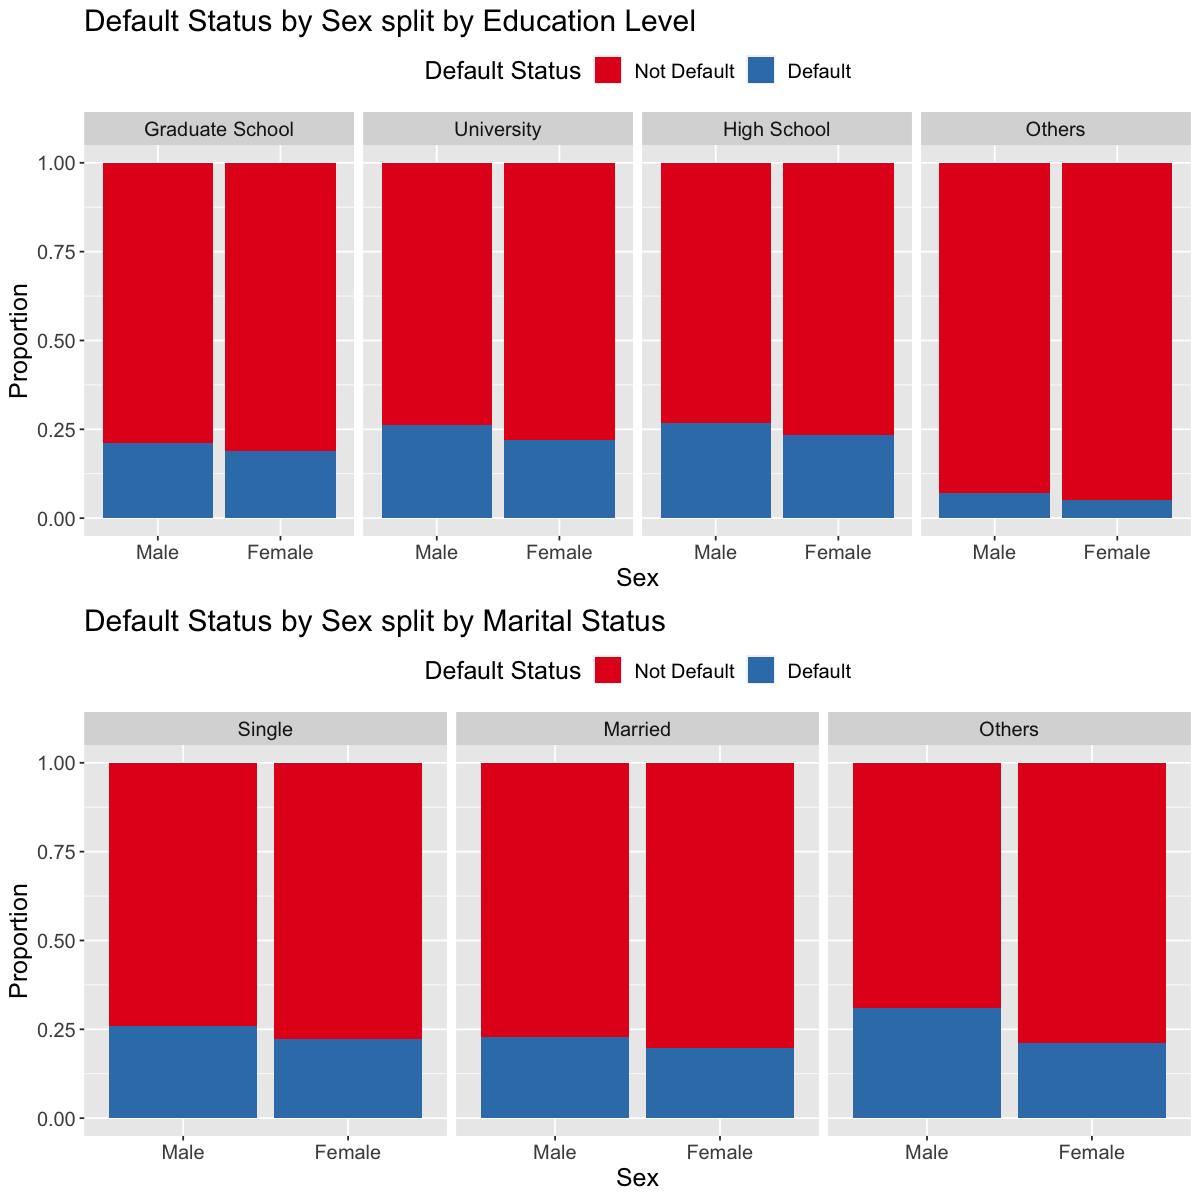

In [306]:
# Proportion of Default Status by Sex split by Education level and Marital Status

options(repr.plot.width = 10, repr.plot.height = 10) 

default_vs_sex_edu <- credit_card_train |>
    group_by(sex, education, y) |>
    summarise(n=n()) |>
    ggplot(aes(x=as_factor(sex),y=n,fill=as_factor(y))) +
    geom_bar(stat="identity",position="fill") +
    facet_wrap(~ education,ncol=4, labeller = labeller(
        education = c("1" = "Graduate School", "2" = "University", "3" = "High School", "4" = "Others"))) +
    scale_x_discrete(labels = c("1"="Male","2"="Female")) +
    scale_fill_brewer(labels = c('Not Default','Default'),palette = "Set1") +
    labs(x = "Sex"
        ,y = "Proportion"
        ,fill = "Default Status"
        ,title= "Default Status by Sex split by Education Level") +
    theme(text = element_text(size=15),legend.position = "top")

default_vs_sex_mar <- credit_card_train |>
    group_by(sex, marital_status, y) |>
    summarise(n=n()) |>
    ggplot(aes(x=as_factor(sex),y=n,fill=as_factor(y))) +
    geom_bar(stat="identity",position="fill") +
    facet_wrap(~ marital_status,ncol=4, labeller = labeller(
        marital_status = c("1" = "Single", "2" = "Married", "3" = "Others"))) +
    scale_fill_brewer(labels = c('Not Default','Default'),palette = "Set1") +
    scale_x_discrete(labels = c("1"="Male","2"="Female")) +
    labs(x = "Sex"
        ,y = "Proportion"
        ,fill = "Default Status"
        ,title= "Default Status by Sex split by Marital Status") +
    theme(text = element_text(size=15),legend.position = "top")

grid.arrange(default_vs_sex_edu,default_vs_sex_mar)

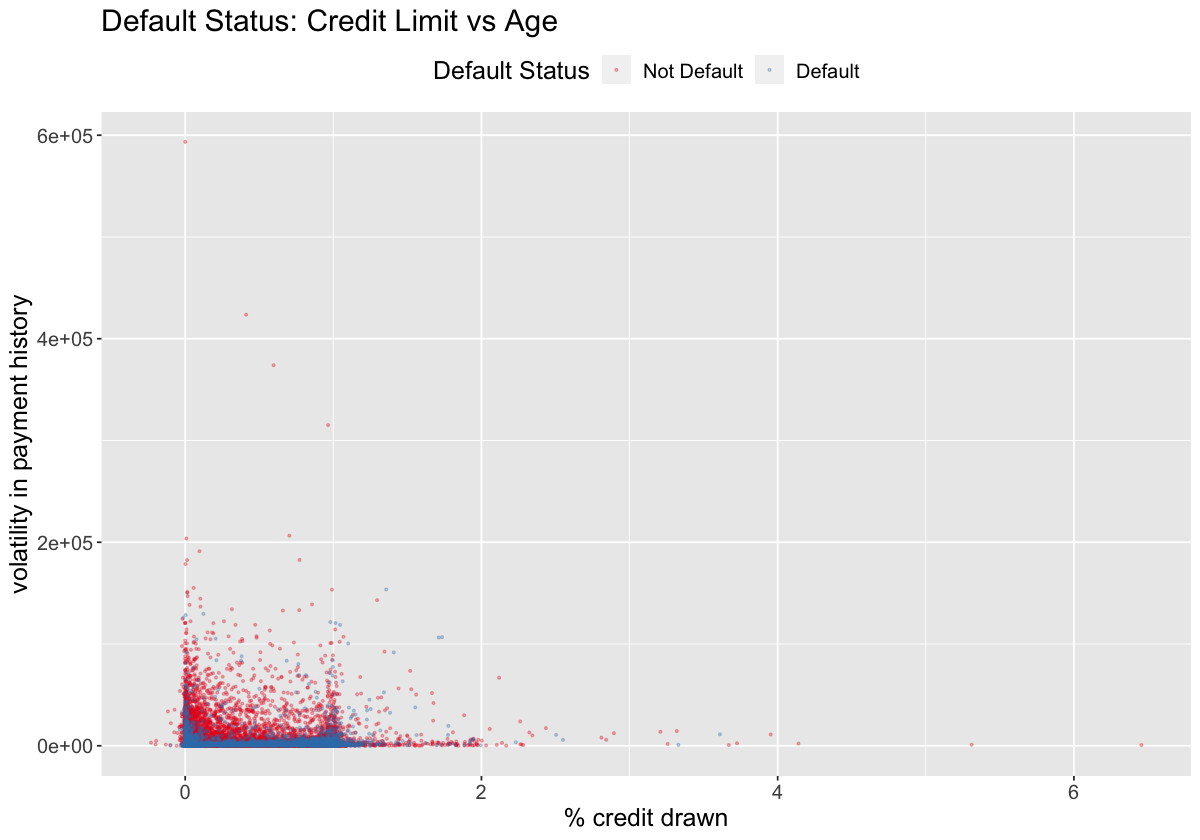

In [315]:
# Scatterplot of default status by credit limit and age

options(repr.plot.width = 10, repr.plot.height = 7) 

age_vs_credit_limit <- credit_card_train |>
    ggplot(aes(x=balance_pct_09,y=volatility, color=as_factor(y))) +
    geom_point(alpha=0.3, size = 0.5) +
    scale_color_brewer(labels = c('Not Default','Default'),palette = "Set1") +
    scale_x_continuous(labels = comma) +
    labs(x="% credit drawn"
        , y="volatility in payment history"
        , color = "Default Status"
        , title= "Default Status: Credit Limit vs Age") +
    theme(text = element_text(size=15),legend.position = "top")

age_vs_credit_limit

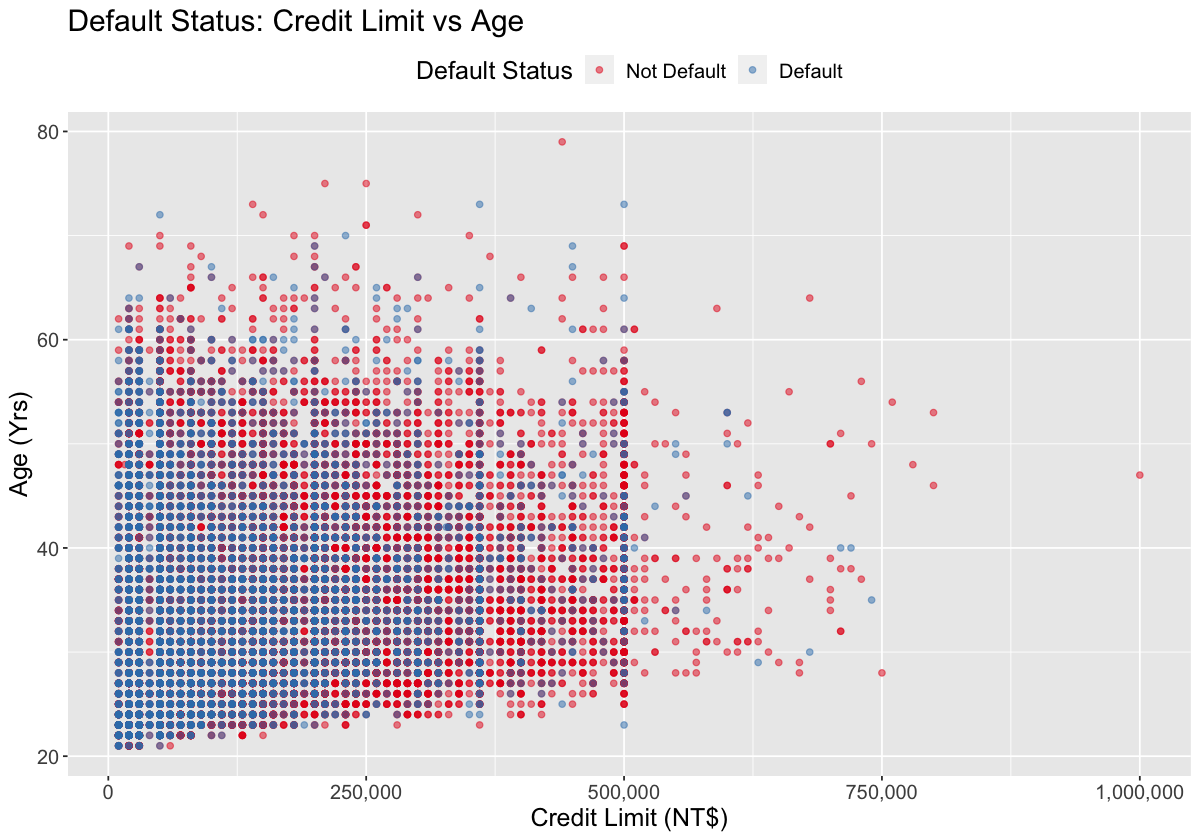

In [317]:
# Scatterplot of default status by credit limit and age

options(repr.plot.width = 10, repr.plot.height = 7) 

age_vs_credit_limit <- credit_card_train |>
    ggplot(aes(x=credit_limit,y=age, color=as_factor(y))) +
    geom_point(alpha=0.5) +
    scale_color_brewer(labels = c('Not Default','Default'),palette = "Set1") +
    scale_x_continuous(labels = comma) +
    labs(x="Credit Limit (NT$)"
        , y="Age (Yrs)"
        , color = "Default Status"
        , title= "Default Status: Credit Limit vs Age") +
    theme(text = element_text(size=15),legend.position = "top")

age_vs_credit_limit

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



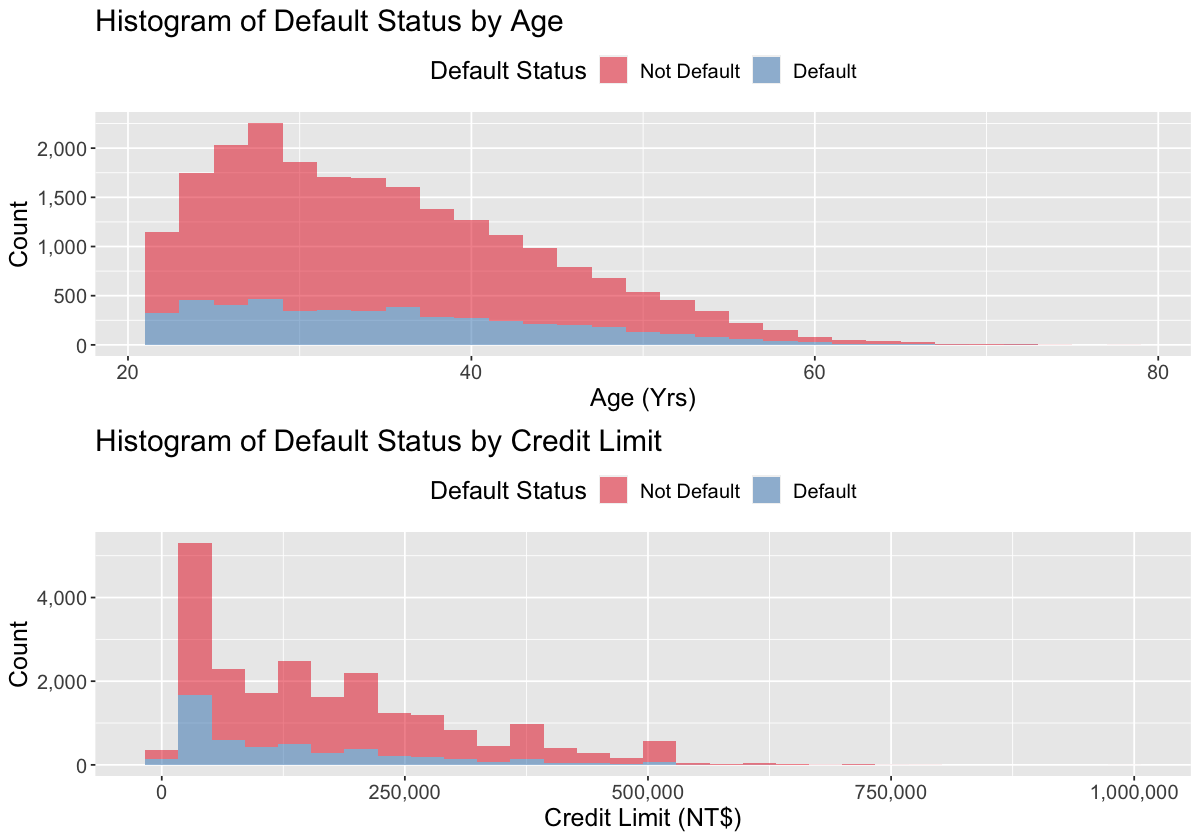

In [318]:
# Histogram of default status by credit limit and age

options(repr.plot.width = 10, repr.plot.height = 7) 

density_plot_age <- credit_card_train |>
    ggplot()+
    geom_histogram(aes(x=age, fill = as_factor(y)),alpha=0.5)+
    scale_fill_brewer(labels = c('Not Default','Default'),palette = "Set1")+
    scale_x_continuous(labels = comma)+
    scale_y_continuous(labels = comma)+
    labs(x="Age (Yrs)"
        , y="Count"
        , fill="Default Status"
        , title="Histogram of Default Status by Age")+
    theme(text = element_text(size=15),legend.position = "top")


density_plot_credit_limit <- credit_card_train |>
    ggplot()+
    geom_histogram(aes(x=credit_limit, fill = as_factor(y)),alpha=0.5)+
    scale_fill_brewer(labels = c('Not Default','Default'),palette = "Set1")+
    scale_x_continuous(labels = comma)+
    scale_y_continuous(labels = comma)+
    labs(x="Credit Limit (NT$)"
        , y="Count"
        , fill="Default Status"
        , title="Histogram of Default Status by Credit Limit")+
    theme(text = element_text(size=15),legend.position = "top")

grid.arrange(density_plot_age,density_plot_credit_limit)

### 2.3 Model Fitting and Testing

In [319]:
# Setting up paramaters 
set.seed(154)

# create v_fold
cc_vfold <- vfold_cv(credit_card_train, v = 4, strata = y)

# set model specification
knn_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) |>
      set_engine("kknn") |>
      set_mode("classification")

# create a tibble of values to try
k_vals <- tibble(neighbors = seq(from = 1, to = 250, by = 25))

In [345]:
# 1. Model using strictly the categorical factors
cc_categorical_recipe <- recipe(y ~ sex + marital_status + education + status_09, data = credit_card_train) |>
                        step_upsample(y, over_ratio = 1) |>
                        prep()

cc_categorical_fit <- workflow() |> 
    add_recipe(cc_categorical_recipe) |> 
    add_model(knn_spec) |> 
    tune_grid(resamples = cc_vfold, grid = k_vals) |> 
    collect_metrics()



# 2. Model using strcitly new features
cc_new_features_recipe <- recipe(y ~ balance_pct_04 + volatility, data = credit_card_train) |>
                        step_scale(all_numeric_predictors()) |> 
                        step_center(all_numeric_predictors()) |> 
                        step_upsample(y, over_ratio = 1) |>
                        prep()

cc_new_features_fit <- workflow() |> 
    add_recipe(cc_new_features_recipe) |> 
    add_model(knn_spec) |> 
    tune_grid(resamples = cc_vfold, grid = k_vals) |> 
    collect_metrics()



# 3. Model using best of raw and engineerered features
cc_high_correlation_recipe <- recipe(y ~ sex + marital_status + education + status_09 + credit_limit + balance_pct_04 + volatility, data = credit_card_train) |>
                        step_scale(all_numeric_predictors()) |> 
                        step_center(all_numeric_predictors()) |>
                        step_upsample(y, over_ratio = 1) |>
                        prep()

cc_high_correlation_fit <- workflow() |> 
    add_recipe(cc_high_correlation_recipe) |> 
    add_model(knn_spec) |> 
    tune_grid(resamples = cc_vfold, grid = k_vals) |> 
    collect_metrics()

New names:
* `mean` -> `mean...2`
* `mean` -> `mean...3`
New names:
* `mean` -> `mean...4`


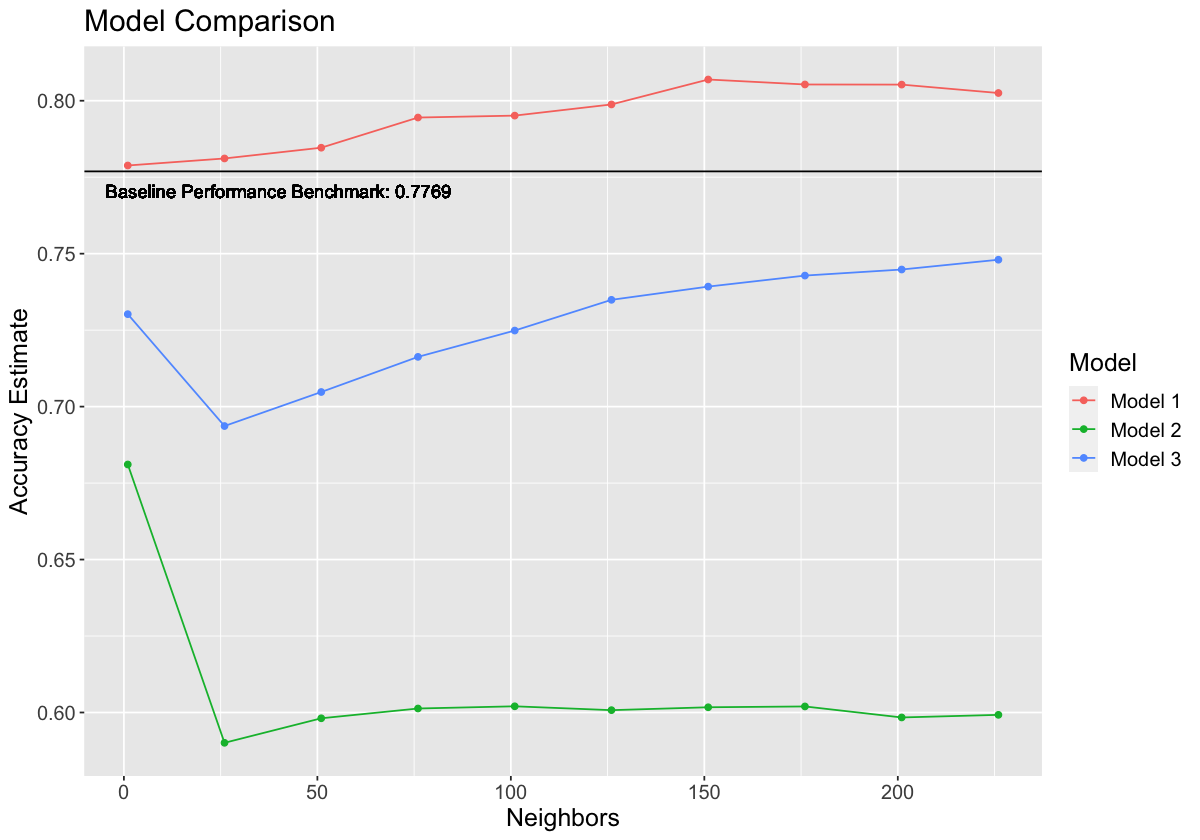

In [351]:
# Creating summary table
summary_table <- select(filter(cc_categorical_fit, .metric == "accuracy"), neighbors, mean) |>
    bind_cols(select(filter(cc_new_features_fit, .metric == "accuracy"), mean)) |>
    bind_cols(select(filter(cc_high_correlation_fit, .metric == "accuracy"), mean))

colnames(summary_table) <- c('neighbors','Model 1','Model 2','Model 3')

summary_table <- summary_table |>
    pivot_longer(cols = -neighbors,
    names_to = "grouping",
    values_to = "accuracy")

# Plotting results
options(repr.plot.width = 10, repr.plot.height = 7)
cv_vold_plot <- summary_table |>
    ggplot() +
    geom_point(aes(x = neighbors, y = accuracy, colour = grouping)) +
    geom_line(aes(x = neighbors, y = accuracy, colour = grouping)) +
    labs(x = "Neighbors", y="Accuracy Estimate", colour = "Model") +
    geom_hline(yintercept = 0.7769, colour = "black") +
    geom_text(aes(40, 0.7769, label = "Baseline Performance Benchmark: 0.7769", vjust = 2))+
    ggtitle("Model Comparison") +
    scale_color_discrete(labels = c("Model 1", "Model 2", "Model 3"))+
    theme(text = element_text(size=15))

cv_vold_plot

### 2.4 Final Model Selection and Results

In [355]:
# specify the KNN model to neighbors = 100
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 150) |> 
    set_engine("kknn") |>
    set_mode("classification")    

# fit the model
knn_final_fit <- workflow() |> 
    add_recipe(cc_categorical_recipe) |> 
    add_model(knn_spec) |> 
    fit(data = credit_card_train) #fit to the whole train data now

# test
cc_test_predictions <- predict(knn_final_fit, credit_card_test) |>
    bind_cols(credit_card_test)

# regular summary
cc_test_predictions |> 
    metrics(truth = y, estimate = .pred_class) |>
    filter(.metric == "accuracy")

# confusion matrix
cc_test_predictions |>
    conf_mat(truth = y, estimate = .pred_class)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7966491


          Truth
Prediction    0    1
         0 5545 1301
         1  204  351

In [362]:
cc_test_predictions |>
    group_by(.pred_class) |>
    summarize(default_count = n()) |>
    mutate(default_pct = default_count/sum(default_count))

.pred_class,default_count,default_pct
<fct>,<int>,<dbl>
0,6846,0.92501013
1,555,0.07498987


In [363]:
credit_card_test |>
    group_by(y) |>
    summarize(default_count=n())|>
    mutate(default_pct = default_count/sum(default_count))

y,default_count,default_pct
<fct>,<int>,<dbl>
0,5749,0.7767869
1,1652,0.2232131


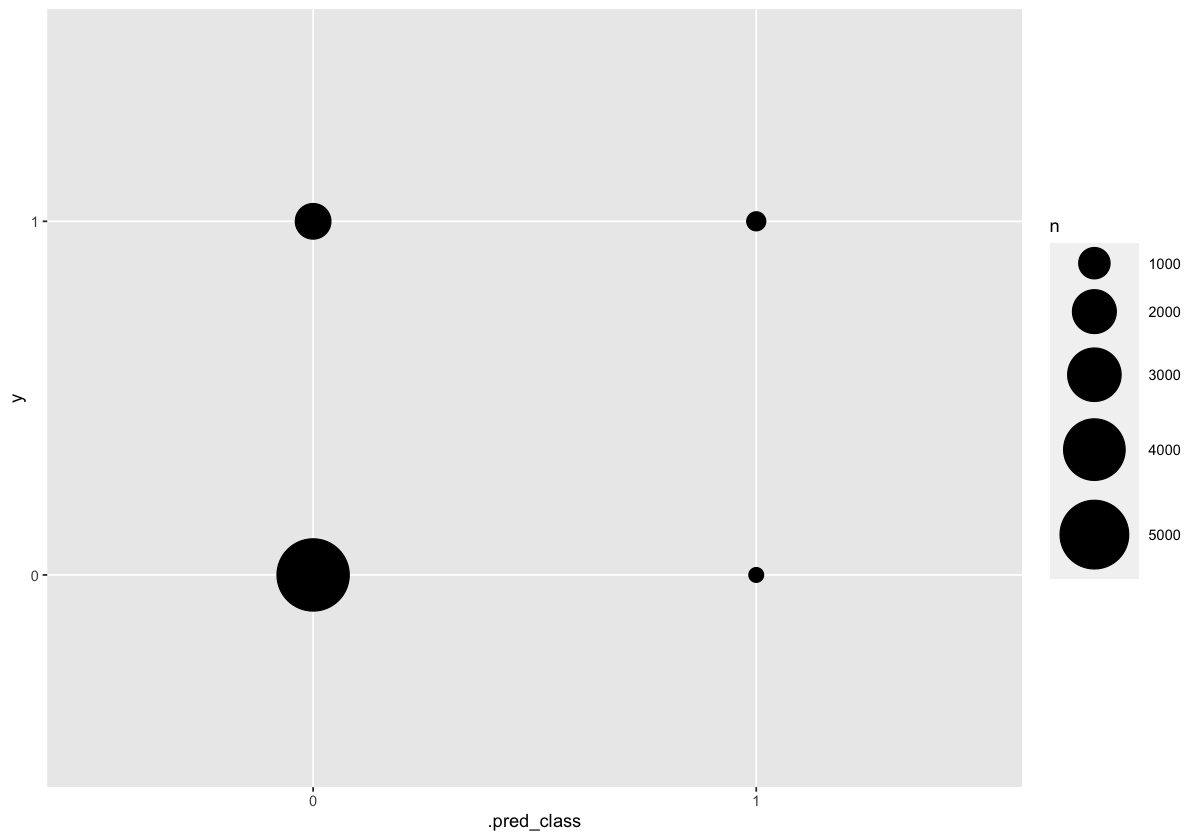

In [364]:
cc_test_predictions |>
    select(.pred_class,y) |>
    ggplot(aes(x = .pred_class, y = y)) +
    geom_count() + 
    scale_size_area(max_size = 20)

## 3. Discussion
___

TODO: !!! DELETE AFTER

* summarize what you found
* discuss whether this is what you expected to find? (initial Qs below to start you out)
* discuss what impact could such findings have? (done)
* discuss what future questions could this lead to? (done)
____

**We expect to find varying degrees of relationship between default status and direct categorical variables.**
1. Positive relationship between default status vs education. 
2. No relationship between default status vs age, sex, and marital status.


**The findings could have a broad positive impact. Specifically, it could:**
1. Create a less risky credit environment for both banks and credit card users
2. Develop educational programs for people at higher risk to minimize chance of systemic credit defaults.

**This could lead us to future questions like:**
1. What role does employment play in the default status of a credit card?

## 4. References
___

TODO: !!! DELETE AFTER

* At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references). 
* Make sure to cite the source of your data as well. 
